# Optimizing and Tuning Spark Applications

In the previous chapter, we elaborated on how to work with Datasets in Java and
Scala. We explored how Spark manages memory to accommodate Dataset constructs
as part of its unified and high-level API, and we considered the costs associated with
using Datasets and how to mitigate those costs.
Besides mitigating costs, we also want to consider how to optimize and tune Spark. In
this chapter, we will discuss a set of Spark configurations that enable optimizations,
look at Spark’s family of join strategies, and inspect the Spark UI, looking for clues to
bad behavior.

## Optimizing and Tuning Spark for Efficiency
While Spark has many configurations for tuning, this book will only cover a handful
of the most important and commonly tuned configurations. For a comprehensive list
grouped by functional themes, you can peruse the documentation.
### Viewing and Setting Apache Spark Configurations 
There are three ways you can get and set Spark properties. The first is through a set of
configuration files. In your deployment’s SPARK_HOME directory (where you installed
Spark), there are a number # of config files: conf/spark-defaults.conf.template, conf/
log4j.properties.template, and conf/spark-env.sh.template. Changing the default values
in these files and saving them without the .template suffix instructs Spark to use these
new values.

Configuration changes in the conf/spark-defaults.conf file apply to
the Spark cluster and all Spark applications submitted to the
cluster.

The second way is to specify Spark configurations directly in your Spark application
or on the command line when submitting the application with spark-submit, using
the --conf flag: 
~~~
spark-submit --conf spark.sql.shuffle.partitions=5 --conf
"spark.executor.memory=2g" --class main.scala.chapter7.SparkConfig_7_1 jars/mainscala-chapter7_2.12-1.0.jar
~~~
Here’s how you would do this in the Spark application itself:
~~~
// In Scala
import org.apache.spark.sql.SparkSession
def printConfigs(session: SparkSession) = {
 // Get conf
 val mconf = session.conf.getAll
 // Print them
 for (k <- mconf.keySet) { println(s"${k} -> ${mconf(k)}\n") }
}
def main(args: Array[String]) {
// Create a session
val spark = SparkSession.builder
 .config("spark.sql.shuffle.partitions", 5)
 .config("spark.executor.memory", "2g")
 .master("local[*]")
 .appName("SparkConfig")
 .getOrCreate()
printConfigs(spark)
spark.conf.set("spark.sql.shuffle.partitions",
 spark.sparkContext.defaultParallelism)
println(" ****** Setting Shuffle Partitions to Default Parallelism")
printConfigs(spark)
}
spark.driver.host -> 10.8.154.34
spark.driver.port -> 55243
spark.app.name -> SparkConfig
spark.executor.id -> driver
spark.master -> local[*]
spark.executor.memory -> 2g
spark.app.id -> local-1580162894307
spark.sql.shuffle.partitions -> 5
~~~
The third option is through a programmatic interface via the Spark shell. As with
everything else in Spark, APIs are the primary method of interaction. Through the
SparkSession object, you can access most Spark config settings.
In a Spark REPL, for example, this Scala code shows the Spark configs on a local host
where Spark is launched in local mode (for details on the different modes available,
see “Deployment modes” on page 12 in Chapter 1):
~~~
// In Scala
// mconf is a Map[String, String]
scala> val mconf = spark.conf.getAll
...
scala> for (k <- mconf.keySet) { println(s"${k} -> ${mconf(k)}\n") }
spark.driver.host -> 10.13.200.101
spark.driver.port -> 65204
spark.repl.class.uri -> spark://10.13.200.101:65204/classes
spark.jars ->
spark.repl.class.outputDir -> /private/var/folders/jz/qg062ynx5v39wwmfxmph5nn...
spark.app.name -> Spark shell
spark.submit.pyFiles ->
spark.ui.showConsoleProgress -> true
spark.executor.id -> driver
spark.submit.deployMode -> client
spark.master -> local[*]
spark.home -> /Users/julesdamji/spark/spark-3.0.0-preview2-bin-hadoop2.7
spark.sql.catalogImplementation -> hive
spark.app.id -> local-1580144503745
~~~
You can also view only the Spark SQL–specific Spark configs:
~~~
// In Scala
spark.sql("SET -v").select("key", "value").show(5, false)
# In Python
spark.sql("SET -v").select("key", "value").show(n=5, truncate=False)
~~~
Alternatively, you can access Spark’s current configuration through the Spark UI’s
Environment tab, which we discuss later in this chapter, as read-only values, as shown
in Figure 7-1.
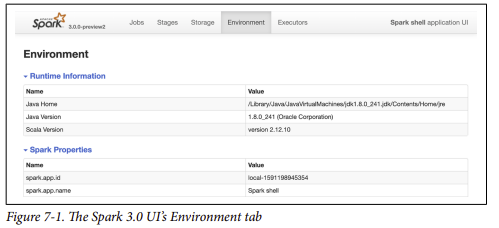
To set or modify an existing configuration programmatically, first check if the prop‐
erty is modifiable. spark.conf.isModifiable("<config_name>") will return true or
false. All modifiable configs can be set to new values using the API:
~~~
// In Scala
scala> spark.conf.get("spark.sql.shuffle.partitions")
res26: String = 200
scala> spark.conf.set("spark.sql.shuffle.partitions", 5)
scala> spark.conf.get("spark.sql.shuffle.partitions")
res28: String = 5
# In Python
>>> spark.conf.get("spark.sql.shuffle.partitions")
'200'
>>> spark.conf.set("spark.sql.shuffle.partitions", 5)
>>> spark.conf.get("spark.sql.shuffle.partitions")
'5'
~~~
Among all the ways that you can set Spark properties, an order of precedence deter‐
mines which values are honored. Any values or flags defined in spark-defaults.conf
will be read first, followed by those supplied on the command line with sparksubmit, and finally those set via SparkSession in the Spark application. All these
properties will be merged, with any duplicate properties reset in the Spark application
taking precedence. Likewise, values supplied on the command line will supersede set‐
tings in the configuration file, provided they are not overwritten in the application
itself.

Tweaking or supplying the right configurations helps with performance, as you’ll see
in the next section. The recommendations here are derived from practitioners’ obser‐
vations in the community and focus on how to maximize cluster resource utilization
for Spark to accommodate large-scale workloads.

## Scaling Spark for Large Workloads
Large Spark workloads are often batch jobs—some run on a nightly basis, while some
are scheduled at regular intervals during the day. In either case, these jobs may pro‐
cess tens of terabytes of data or more. To avoid job failures due to resource starvation
or gradual performance degradation, there are a handful of Spark configurations that
you can enable or alter. These configurations affect three Spark components: the
Spark driver, the executor, and the shuffle service running on the executor.
The Spark driver’s responsibility is to coordinate with the cluster manager to launch
executors in a cluster and schedule Spark tasks on them. With large workloads, you
may have hundreds of tasks. This section explains a few configurations you can tweak
or enable to optimize your resource utilization, parallelize tasks, and avoid bottle‐
necks for large numbers of tasks. Some of the optimization ideas and insights have
been derived from big data companies like Facebook that use Spark at terabyte scale,
which they shared with the Spark community at the Spark + AI Summit.1
### Static versus dynamic resource allocation
When you specify compute resources as command-line arguments to spark-submit,
as we did earlier, you cap the limit. This means that if more resources are needed later
as tasks queue up in the driver due to a larger than anticipated workload, Spark can‐
not accommodate or allocate extra resources.
If instead you use Spark’s dynamic resource allocation configuration, the Spark driver
can request more or fewer compute resources as the demand of large workloads flows
and ebbs. In scenarios where your workloads are dynamic—that is, they vary in their
demand for compute capacity—using dynamic allocation helps to accommodate sud‐
den peaks.

One use case where this can be helpful is streaming, where the data flow volume may
be uneven. Another is on-demand data analytics, where you might have a high vol‐
ume of SQL queries during peak hours. Enabling dynamic resource allocation allows
Spark to achieve better utilization of resources, freeing executors when not in use and
acquiring new ones when needed.

As well as when working with large or varying workloads, dynamic
allocation is also useful in a multitenant environment, where Spark
may be deployed alongside other applications or services in YARN,
Mesos, or Kubernetes. Be advised, however, that Spark’s shifting
resource demands may impact other applications demanding
resources at the same time.

To enable and configure dynamic allocation, you can use settings like the following.
Note that the numbers here are arbitrary; the appropriate settings will depend on the
nature of your workload and they should be adjusted accordingly. Some of these
configs cannot be set inside a Spark REPL, so you will have to set them
programmatically:

spark.dynamicAllocation.enabled true
spark.dynamicAllocation.minExecutors 2
spark.dynamicAllocation.schedulerBacklogTimeout 1m
spark.dynamicAllocation.maxExecutors 20
spark.dynamicAllocation.executorIdleTimeout 2min

By default spark.dynamicAllocation.enabled is set to false. When enabled with
the settings shown here, the Spark driver will request that the cluster manager create
two executors to start with, as a minimum (spark.dynamicAllocation.minExecu
tors). As the task queue backlog increases, new executors will be requested each time
the backlog timeout (spark.dynamicAllocation.schedulerBacklogTimeout) is
exceeded. In this case, whenever there are pending tasks that have not been scheduled
for over 1 minute, the driver will request that a new executor be launched to schedule
backlogged tasks, up to a maximum of 20 (spark.dynamicAllocation.maxExecu
tors). By contrast, if an executor finishes a task and is idle for 2 minutes
(spark.dynamicAllocation.executorIdleTimeout), the Spark driver will terminate
it.
### Configuring Spark executors’ memory and the shuffle service
Simply enabling dynamic resource allocation is not sufficient. You also have to under‐
stand how executor memory is laid out and used by Spark so that executors are not
starved of memory or troubled by JVM garbage collection.
The amount of memory available to each executor is controlled by
spark.executor.memory. This is divided into three sections, as depicted in
Figure 7-2: execution memory, storage memory, and reserved memory. The default
division is 60% for execution memory and 40% for storage, after allowing for 300 MB
for reserved memory, to safeguard against OOM errors. The Spark documentation
advises that this will work for most cases, but you can adjust what fraction of
spark.executor.memory you want either section to use as a baseline. When storage
memory is not being used, Spark can acquire it for use in execution memory for exe‐
cution purposes, and vice versa.
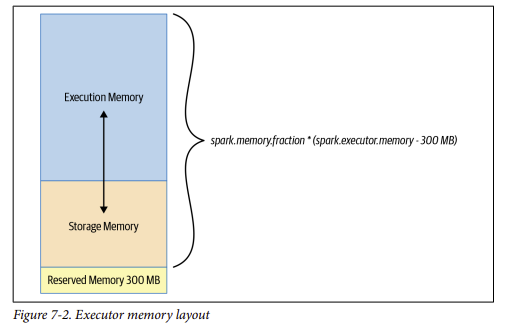
Execution memory is used for Spark shuffles, joins, sorts, and aggregations. Since dif‐
ferent queries may require different amounts of memory, the fraction (spark.mem
ory.fraction is 0.6 by default) of the available memory to dedicate to this can be
tricky to tune but it’s easy to adjust. By contrast, storage memory is primarily used for
caching user data structures and partitions derived from DataFrames.

During map and shuffle operations, Spark writes to and reads from the local disk’s
shuffle files, so there is heavy I/O activity. This can result in a bottleneck, because the default configurations are suboptimal for large-scale Spark jobs. Knowing what con‐
figurations to tweak can mitigate this risk during this phase of a Spark job.

In Table 7-1, we capture a few recommended configurations to adjust so that the map,
spill, and merge processes during these operations are not encumbered by inefficient
I/O and to enable these operations to employ buffer memory before writing the final
shuffle partitions to disk. Tuning the shuffle service running on each executor can
also aid in increasing overall performance for large Spark workloads.
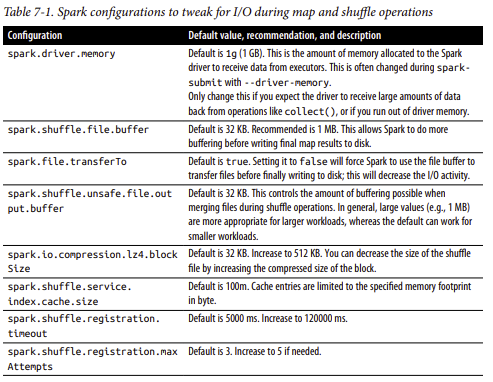
The recommendations in this table won’t work for all situations, but they should give you an idea of how to adjust these configurations based on your workload. Like with everything else in performance tuning, you have to experiment until you find the right
balance.
### Maximizing Spark parallelism
Much of Spark’s efficiency is due to its ability to run multiple tasks in parallel at scale. To understand how you can maximize parallelism—i.e., read and process as much
data in parallel as possible—you have to look into how Spark reads data into memory
from storage and what partitions mean to Spark.

In data management parlance, a partition is a way to arrange data into a subset of
configurable and readable chunks or blocks of contiguous data on disk. These subsets
of data can be read or processed independently and in parallel, if necessary, by more
than a single thread in a process. This independence matters because it allows for
massive parallelism of data processing.

Spark is embarrassingly efficient at processing its tasks in parallel. As you learned in
Chapter 2, for large-scale workloads a Spark job will have many stages, and within each stage there will be many tasks. Spark will at best schedule a thread per task per
core, and each task will process a distinct partition. To optimize resource utilization
and maximize parallelism, the ideal is at least as many partitions as there are cores on
the executor, as depicted in Figure 7-3. If there are more partitions than there are
cores on each executor, all the cores are kept busy. You can think of partitions as
atomic units of parallelism: a single thread running on a single core can work on a
single partition.
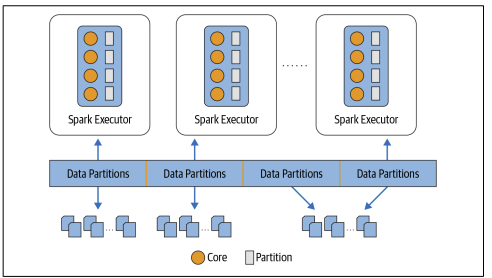
Figure 7-3. Relationship of Spark tasks, cores, partitions, and parallelism

___How partitions are created.___ As mentioned previously, Spark’s tasks process data as partitions read from disk into memory. Data on disk is laid out in chunks or contiguous
file blocks, depending on the store. By default, file blocks on data stores range in size
from 64 MB to 128 MB. For example, on HDFS and S3 the default size is 128 MB
(this is configurable). A contiguous collection of these blocks constitutes a partition.

The size of a partition in Spark is dictated by spark.sql.files.maxPartitionBytes.
The default is 128 MB. You can decrease the size, but that may result in what’s known
as the “small file problem”—many small partition files, introducing an inordinate
amount of disk I/O and performance degradation thanks to filesystem operations
such as opening, closing, and listing directories, which on a distributed filesystem can
be slow.

Partitions are also created when you explicitly use certain methods of the DataFrame
API. For example, while creating a large DataFrame or reading a large file from disk,
you can explicitly instruct Spark to create a certain number of partitions:
~~~
// In Scala
val ds = spark.read.textFile("../README.md").repartition(16)
ds: org.apache.spark.sql.Dataset[String] = [value: string]
ds.rdd.getNumPartitions
res5: Int = 16
val numDF = spark.range(1000L * 1000 * 1000).repartition(16)
numDF.rdd.getNumPartitions
numDF: org.apache.spark.sql.Dataset[Long] = [id: bigint]
res12: Int = 16
~~~
Finally, shuffle partitions are created during the shuffle stage. By default, the number
of shuffle partitions is set to 200 in spark.sql.shuffle.partitions. You can adjust
this number depending on the size of the data set you have, to reduce the amount of
small partitions being sent across the network to executors’ tasks.

The default value for spark.sql.shuffle.partitions is too high for smaller or streaming workloads; you may want to reduce it to a lower value such as the number of cores on the executors or less.

Created during operations like groupBy() or join(), also known as wide transformations, shuffle partitions consume both network and disk I/O resources. During these
operations, the shuffle will spill results to executors’ local disks at the location specified in spark.local.directory. Having performant SSD disks for this operation will
boost the performance.

There is no magic formula for the number of shuffle partitions to set for the shuffle
stage; the number may vary depending on your use case, data set, number of cores,
and the amount of executor memory available—it’s a trial-and-error approach.2

In addition to scaling Spark for large workloads, to boost your performance you’ll
want to consider caching or persisting your frequently accessed DataFrames or tables.
We explore various caching and persistence options in the next section.

## Caching and Persistence of Data
What is the difference between caching and persistence? In Spark they are synonymous. Two API calls, cache() and persist(), offer these capabilities. The latter provides more control over how and where your data is stored—in memory and on disk,serialized and unserialized. Both contribute to better performance for frequently accessed DataFrames or tables.
### DataFrame.cache()
cache() will store as many of the partitions read in memory across Spark executors
as memory allows (see Figure 7-2). While a DataFrame may be fractionally cached,
partitions cannot be fractionally cached (e.g., if you have 8 partitions but only 4.5
partitions can fit in memory, only 4 will be cached). However, if not all your partitions are cached, when you want to access the data again, the partitions that are not cached will have to be recomputed, slowing down your Spark job.

Let’s look at an example of how caching a large DataFrame improves performance
when accessing a DataFrame:
~~~
// In Scala
// Create a DataFrame with 10M records
val df = spark.range(1 * 10000000).toDF("id").withColumn("square", $"id" * $"id")
df.cache() // Cache the data
df.count() // Materialize the cache
res3: Long = 10000000
Command took 5.11 seconds
df.count() // Now get it from the cache
res4: Long = 10000000
Command took 0.44 seconds
~~~
The first count() materializes the cache, whereas the second one accesses the cache,
resulting in a close to 12 times faster access time for this data set.

When you use cache() or persist(), the DataFrame is not fully cached until you invoke an action that goes through every record (e.g., count()). If you use an action like take(1), only one partition will be cached because Catalyst realizes that you do not need to compute all the partitions just to retrieve one record.

Observing how a DataFrame is stored across one executor on a local host, as dis‐
played in Figure 7-4, we can see they all fit in memory (recall that at a low level Data‐
Frames are backed by RDDs).
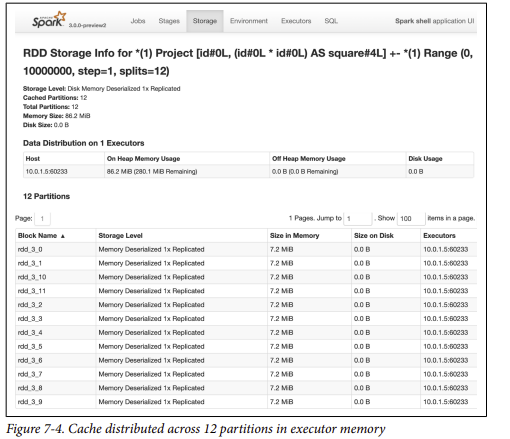

## DataFrame.persist()
persist(StorageLevel.LEVEL) is nuanced, providing control over how your data is
cached via StorageLevel. Table 7-2 summarizes the different storage levels. Data on
disk is always serialized using either Java or Kryo serialization.
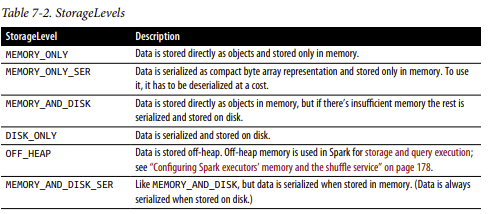
Each StorageLevel (except OFF_HEAP) has an equivalent LEVEL_NAME_2, which means replicate twice on two different Spark executors: MEMORY_ONLY_2, MEMORY_AND_DISK_SER_2, etc. While
this option is expensive, it allows data locality in two places, providing fault tolerance and giving Spark the option to schedule a task local to a copy of the data.

Let’s look at the same example as in the previous section, but using the persist()
method:
~~~
// In Scala
import org.apache.spark.storage.StorageLevel
// Create a DataFrame with 10M records
val df = spark.range(1 * 10000000).toDF("id").withColumn("square", $"id" * $"id")
df.persist(StorageLevel.DISK_ONLY) // Serialize the data and cache it on disk
df.count() // Materialize the cache
res2: Long = 10000000
Command took 2.08 seconds
df.count() // Now get it from the cache
res3: Long = 10000000
Command took 0.38 seconds
~~~
As you can see from Figure 7-5, the data is persisted on disk, not in memory. To
unpersist your cached data, just call DataFrame.unpersist().
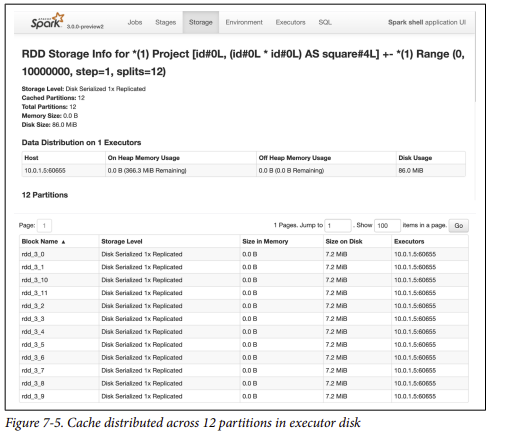
Finally, not only can you cache DataFrames, but you can also cache the tables or views derived from DataFrames. This gives them more readable names in the Spark UI. For example:
~~~
// In Scala
df.createOrReplaceTempView("dfTable")
spark.sql("CACHE TABLE dfTable")
spark.sql("SELECT count(*) FROM dfTable").show()
~~~
### When to Cache and Persist
Common use cases for caching are scenarios where you will want to access a large data set repeatedly for queries or transformations. Some examples include:
* DataFrames commonly used during iterative machine learning training
* DataFrames accessed commonly for doing frequent transformations during ETL or building data pipelines
### When Not to Cache and Persist
Not all use cases dictate the need to cache. Some scenarios that may not warrant caching your DataFrames include:
* DataFrames that are too big to fit in memory
* An inexpensive transformation on a DataFrame not requiring frequent use, regardless of size.

As a general rule you should use memory caching judiciously, as it can incur resource
costs in serializing and deserializing, depending on the StorageLevel used.
Next, we’ll shift our focus to discuss a couple of common Spark join operations that
trigger expensive movement of data, demanding compute and network resources from the cluster, and how we can alleviate this movement by organizing the data.

## A Family of Spark Joins
Join operations are a common type of transformation in big data analytics in which
two data sets, in the form of tables or DataFrames, are merged over a common matching key. Similar to relational databases, the Spark DataFrame and Dataset APIs and Spark SQL offer a series of join transformations: inner joins, outer joins, left joins, right joins, etc. All of these operations trigger a large amount of data movement across Spark executors.

At the heart of these transformations is how Spark computes what data to produce, what keys and associated data to write to the disk, and how to transfer those keys and data to nodes as part of operations like groupBy(), join(), agg(), sortBy(), and reduceByKey(). This movement is commonly referred to as the shuffle.

Spark has five distinct join strategies by which it exchanges, moves, sorts, groups, and
merges data across executors: the broadcast hash join (BHJ), shuffle hash join (SHJ),
shuffle sort merge join (SMJ), broadcast nested loop join (BNLJ), and shuffle-and-replicated nested loop join (a.k.a. Cartesian product join). We’ll focus on only two of
these here (BHJ and SMJ), because they’re the most common ones you’ll encounter.

## Broadcast Hash Join
Also known as a map-side-only join, the broadcast hash join is employed when two
data sets, one small (fitting in the driver’s and executor’s memory) and another large
enough to ideally be spared from movement, need to be joined over certain conditions or columns. Using a Spark broadcast variable, the smaller data set is broadcasted by the driver to all Spark executors, as shown in Figure 7-6, and subsequently joined with the larger data set on each executor. This strategy avoids the large exchange.
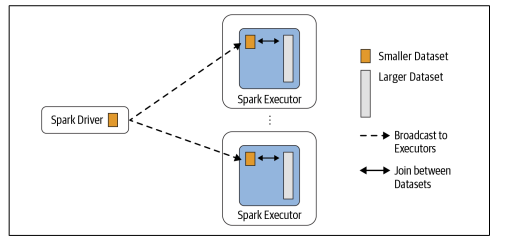
Figure 7-6. BHJ: the smaller data set is broadcast to all executors

By default Spark will use a broadcast join if the smaller data set is less than 10 MB.
This configuration is set in spark.sql.autoBroadcastJoinThreshold; you can decrease or increase the size depending on how much memory you have on each executor and in the driver. If you are confident that you have enough memory you can use a broadcast join with DataFrames larger than 10 MB (even up to 100 MB).

A common use case is when you have a common set of keys between two DataFrames, one holding less information than the other, and you need a merged view of both. For example, consider a simple case where you have a large data set of soccer players around the world, playersDF, and a smaller data set of soccer clubs they play for, clubsDF, and you wish to join them over a common key:
~~~
// In Scala
import org.apache.spark.sql.functions.broadcast
val joinedDF = playersDF.join(broadcast(clubsDF), "key1 === key2")
~~~
In this code we are forcing Spark to do a broadcast join, but it will resort to this type of join by default if the size of the smaller data set is below the spark.sql.autoBroadcastJoinThreshold.

The BHJ is the easiest and fastest join Spark offers, since it does not involve any shuffle of the data set; all the data is available locally to the executor after a broadcast. You just have to be sure that you have enough memory both on the Spark driver’s and the executors’ side to hold the smaller data set in memory.

At any time after the operation, you can see in the physical plan what join operation
was performed by executing:

joinedDF.explain(mode)

In Spark 3.0, you can use joinedDF.explain('mode') to display a readable and
digestible output. The modes include 'simple', 'extended', 'codegen', 'cost', and
'formatted'.

#### When to use a broadcast hash join
Use this type of join under the following conditions for maximum benefit:
* When each key within the smaller and larger data sets is hashed to the same par‐
tition by Spark
* When one data set is much smaller than the other (and within the default config
of 10 MB, or more if you have sufficient memory)
* When you only want to perform an equi-join, to combine two data sets based on
matching unsorted keys
* When you are not worried by excessive network bandwidth usage or OOM errors, because the smaller data set will be broadcast to all Spark executors

Specifying a value of -1 in spark.sql.autoBroadcastJoinThreshold will cause
Spark to always resort to a shuffle sort merge join, which we discuss in the next
section.

## Shuffle Sort Merge Join
The sort-merge algorithm is an efficient way to merge two large data sets over a com‐
mon key that is sortable, unique, and can be assigned to or stored in the same parti‐
tion—that is, two data sets with a common hashable key that end up being on the
same partition. From Spark’s perspective, this means that all rows within each data set
with the same key are hashed on the same partition on the same executor. Obviously,
this means data has to be colocated or exchanged between executors.

As the name indicates, this join scheme has two phases: a sort phase followed by a
merge phase. The sort phase sorts each data set by its desired join key; the merge
phase iterates over each key in the row from each data set and merges the rows if the
two keys match.

By default, the SortMergeJoin is enabled via spark.sql.join.preferSortMerge Join. Here is a code snippet from a notebook of standalone applications available for this chapter in the book’s GitHub repo. The main idea is to take two large DataFrames, with one million records, and join them on two common keys, uid == users_id.

This data is synthetic but illustrates the point:
~~~
// In Scala
import scala.util.Random
// Show preference over other joins for large data sets
// Disable broadcast join
// Generate data
...
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", "-1")
// Generate some sample data for two data sets
var states = scala.collection.mutable.Map[Int, String]()
var items = scala.collection.mutable.Map[Int, String]()
val rnd = new scala.util.Random(42)
// Initialize states and items purchased
states += (0 -> "AZ", 1 -> "CO", 2-> "CA", 3-> "TX", 4 -> "NY", 5-> "MI")
items += (0 -> "SKU-0", 1 -> "SKU-1", 2-> "SKU-2", 3-> "SKU-3", 4 -> "SKU-4",
 5-> "SKU-5")
// Create DataFrames
val usersDF = (0 to 1000000).map(id => (id, s"user_${id}",
 s"user_${id}@databricks.com", states(rnd.nextInt(5))))
 .toDF("uid", "login", "email", "user_state")
val ordersDF = (0 to 1000000)
 .map(r => (r, r, rnd.nextInt(10000), 10 * r* 0.2d,
 states(rnd.nextInt(5)), items(rnd.nextInt(5))))
 .toDF("transaction_id", "quantity", "users_id", "amount", "state", "items")
// Do the join
val usersOrdersDF = ordersDF.join(usersDF, $"users_id" === $"uid")
// Show the joined results
usersOrdersDF.show(false)
~~~
Examining our final execution plan, we notice that Spark employed a SortMergeJoin,
as expected, to join the two DataFrames. The Exchange operation is the shuffle of the
results of the map operation on each executor:

usersOrdersDF.explain() 
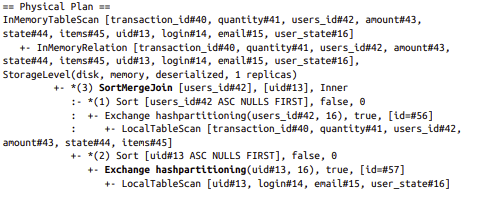
Furthermore, the Spark UI (which we will discuss in the next section) shows three
stages for the entire job: the Exchange and Sort operations happen in the final stage,
followed by merging of the results, as depicted in Figures 7-7 and 7-8. The Exchange
is expensive and requires partitions to be shuffled across the network between executors.
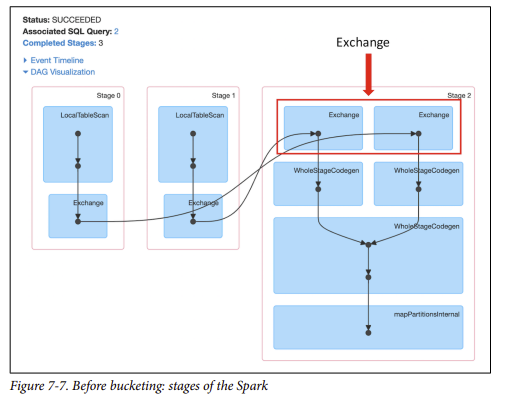
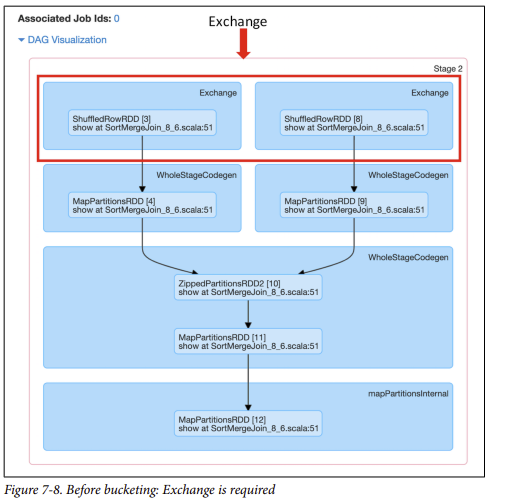
#### Optimizing the shuffle sort merge join
We can eliminate the Exchange step from this scheme if we create partitioned buckets
for common sorted keys or columns on which we want to perform frequent equijoins. That is, we can create an explicit number of buckets to store specific sorted columns (one key per bucket). Presorting and reorganizing data in this way boosts performance, as it allows us to skip the expensive Exchange operation and go straight to WholeStageCodegen.

In the following code snippet from the notebook for this chapter (available in the
book’s GitHub repo) we sort and bucket by the users_id and uid columns on which
we’ll join, and save the buckets as Spark managed tables in Parquet format:
~~~
// In Scala
import org.apache.spark.sql.functions._
import org.apache.spark.sql.SaveMode
// Save as managed tables by bucketing them in Parquet format
usersDF.orderBy(asc("uid"))
 .write.format("parquet")
 .bucketBy(8, "uid")
 .mode(SaveMode.OverWrite)
 .saveAsTable("UsersTbl")
ordersDF.orderBy(asc("users_id"))
 .write.format("parquet")
 .bucketBy(8, "users_id")
 .mode(SaveMode.OverWrite)
 .saveAsTable("OrdersTbl")
// Cache the tables
spark.sql("CACHE TABLE UsersTbl")
spark.sql("CACHE TABLE OrdersTbl")
// Read them back in
val usersBucketDF = spark.table("UsersTbl")
val ordersBucketDF = spark.table("OrdersTbl")
// Do the join and show the results
val joinUsersOrdersBucketDF = ordersBucketDF
 .join(usersBucketDF, $"users_id" === $"uid")
joinUsersOrdersBucketDF.show(false)
~~~
The joined output is sorted by uid and users_id, because we saved the tables sorted
in ascending order. As such, there’s no need to sort during the SortMergeJoin. Looking at the Spark UI (Figure 7-9), we can see that we skipped the Exchange and went straight to WholeStageCodegen.

The physical plan also shows no Exchange was performed, compared to the physical
plan before bucketing:

joinUsersOrdersBucketDF.explain()
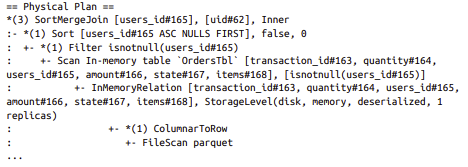
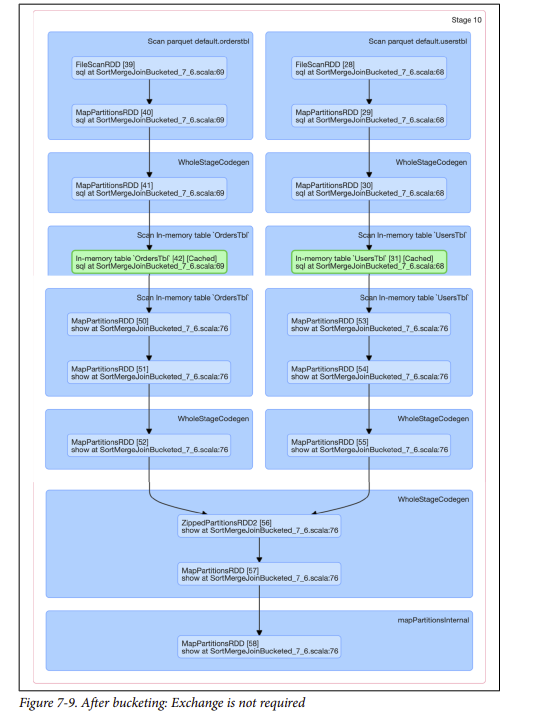
#### When to use a shuffle sort merge join
Use this type of join under the following conditions for maximum benefit:
* When each key within two large data sets can be sorted and hashed to the same
partition by Spark
* When you want to perform only equi-joins to combine two data sets based on
matching sorted keys
* When you want to prevent Exchange and Sort operations to save large shuffles
across the network

So far we have covered operational aspects related to tuning and optimizing Spark,
and how Spark exchanges data during two common join operations. We also demonstrated how you can boost the performance of a shuffle sort merge join operation by using bucketing to avoid large exchanges of data.

As you’ve seen in the preceding figures, the Spark UI is a useful way to visualize these
operations. It shows collected metrics and the state of the program, revealing a wealth
of information and clues about possible performance bottlenecks. In the final section
of this chapter, we discuss what to look for in the Spark UI.

## Inspecting the Spark UI
Spark provides an elaborate web UI that allows us to inspect various components of
our applications. It offers details on memory usage, jobs, stages, and tasks, as well as
event timelines, logs, and various metrics and statistics that can give you insight into
what transpires in your Spark applications, both at the Spark driver level and in individual executors.

A spark-submit job will launch the Spark UI, and you can connect to it on the local
host (in local mode) or through the Spark driver (in other modes) at the default port
4040.
### Journey Through the Spark UI Tabs
The Spark UI has six tabs, as shown in Figure 7-10, each providing opportunities for
exploration. Let’s take a look at what each tab reveals to us.
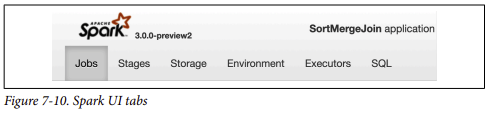
This discussion applies to Spark 2.x and Spark 3.0. While much of the UI is the same
in Spark 3.0, it also adds a seventh tab, Structured Streaming. This is previewed in
Chapter 12.

#### Jobs and Stages
As you learned in Chapter 2, Spark breaks an application down into jobs, stages, and
tasks. The Jobs and Stages tabs allow you to navigate through these and drill down to
a granular level to examine the details of individual tasks. You can view their completion status and review metrics related to I/O, memory consumption, duration of execution, etc.

Figure 7-11 shows the Jobs tab with the expanded Event Timeline, showing when executors were added to or removed from the cluster. It also provides a tabular list of all completed jobs in the cluster. The Duration column indicates the time it took for
each job (identified by the Job Id in the first column) to finish. If this time is high, it’s a good indication that you might want to investigate the stages in that job to see what tasks might be causing delays. From this summary page you can also access a details
page for each job, including a DAG visualization and list of completed stages.
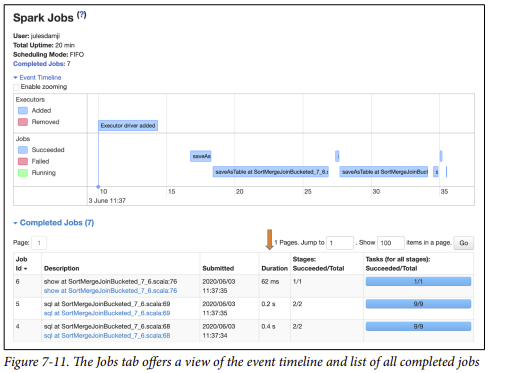
The Stages tab provides a summary of the current state of all stages of all jobs in the
application. You can also access a details page for each stage, providing a DAG and
metrics on its tasks (Figure 7-12). As well as some other optional statistics, you can
see the average duration of each task, time spent in garbage collection (GC), and
number of shuffle bytes/records read. If shuffle data is being read from remote execu‐
tors, a high Shuffle Read Blocked Time can signal I/O issues. A high GC time signals
too many objects on the heap (your executors may be memory-starved). If a stage’s
max task time is much larger than the median, then you probably have data skew
caused by uneven data distribution in your partitions. Look for these tell-tale signs.
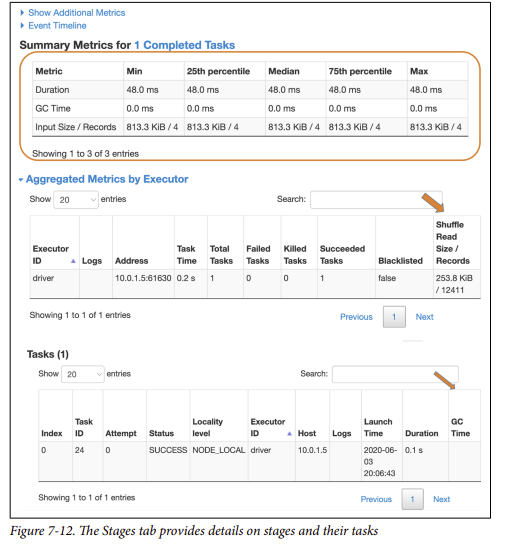
You can also see aggregated metrics for each executor and a breakdown of the indi‐
vidual tasks on this page.

#### Executors
The Executors tab provides information on the executors created for the application.
As you can see in Figure 7-13, you can drill down into the minutiae of details about
resource usage (disk, memory, cores), time spent in GC, amount of data written and
read during shuffle, etc.
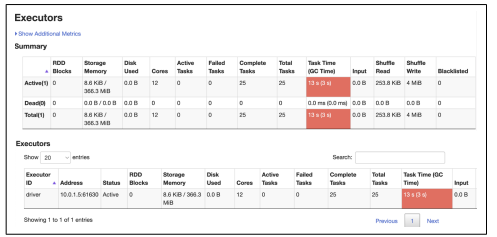
Figure 7-13. The Executors tab shows granular statistics and metrics on the executors
used by your Spark application

In addition to the summary statistics, you can view how memory is used by each
individual executor, and for what purpose. This also helps to examine resource usage
when you have used the cache() or persist() method on a DataFrame or managed
table, which we discuss next.
#### Storage
In the Spark code in “Shuffle Sort Merge Join” we cached two managed tables after
bucketing. The Storage tab, shown in Figure 7-14, provides information on any tables
or DataFrames cached by the application as a result of the cache() or persist()
method.
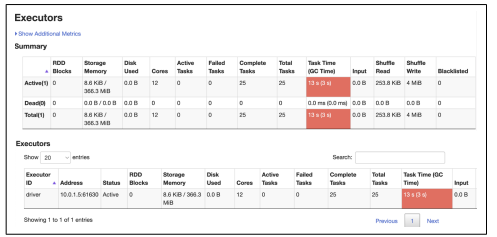
Going a bit further by clicking on the link “In-memory table `UsersTbl`” in
Figure 7-14 displays how the table is cached in memory and on disk across 1 executor
and 8 partitions—this number corresponds to the number of buckets we created for
this table (see Figure 7-15).
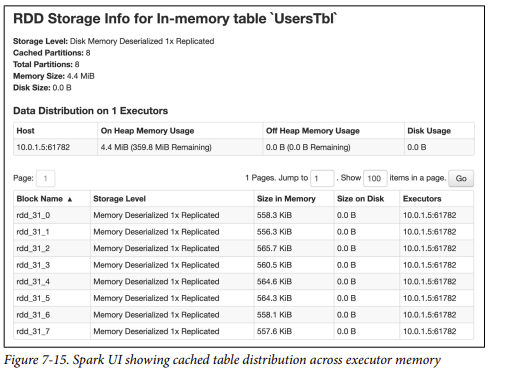
#### SQL
The effects of Spark SQL queries that are executed as part of your Spark application
are traceable and viewable through the SQL tab. You can see when the queries were
executed and by which jobs, and their duration. For example, in our SortMergeJoin
example we executed some queries; all of them are displayed in Figure 7-16, with
links to drill further down.
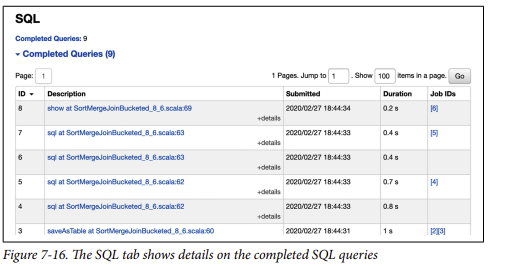
Clicking on the description of a query displays details of the execution plan with all
the physical operators, as shown in Figure 7-17. Under each physical operator of the
plan—here, Scan In-memory table, HashAggregate, and Exchange—are SQL metrics.
These metrics are useful when we want to inspect the details of a physical operator
and discover what transpired: how many rows were scanned, how many shuffle bytes
were written, etc.
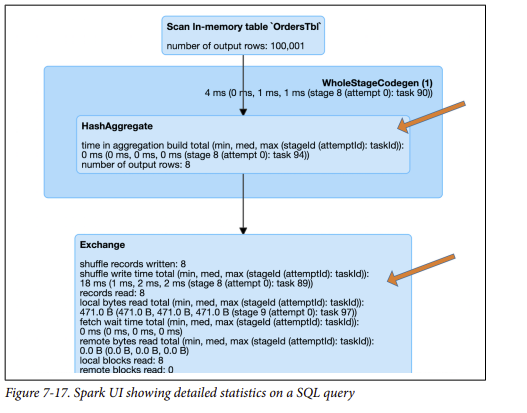
#### Environment
The Environment tab, shown in Figure 7-18, is just as important as the others. Know‐
ing about the environment in which your Spark application is running reveals many
clues that are useful for troubleshooting. In fact, it’s imperative to know what environment variables are set, what jars are included, what Spark properties are set (and
their respective values, especially if you tweaked some of the configs mentioned in
“Optimizing and Tuning Spark for Efficiency” on page 173), what system properties
are set, what runtime environment (such as JVM or Java version) is used, etc. All
these read-only details are a gold mine of information supplementing your investigative efforts should you notice any abnormal behavior in your Spark application.
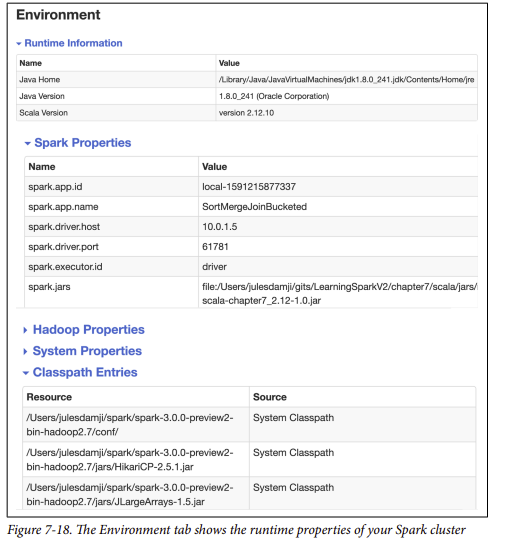
#### Debugging Spark applications
In this section, we have navigated through the various tabs in the Spark UI. As you’ve
seen, the UI provides a wealth of information that you can use for debugging and
troubleshooting issues with your Spark applications. In addition to what we’ve covered here, it also provides access to both driver and executor stdout/stderr logs,
where you might have logged debugging information.
Debugging through the UI is a different process than stepping through an application
in your favorite IDE—more like sleuthing, following trails of bread crumbs—though if you prefer that approach, you can also debug a Spark application in an IDE such as
IntelliJ IDEA on a local host.

The Spark 3.0 UI tabs reveal insightful bread crumbs about what happened, along
with access to both driver and executor stdout/stderr logs, where you might have log‐
ged debugging information.

Initially, this plethora of information can be overwhelming to a novice. But with time
you’ll gain an understanding of what to look for in each tab, and you’ll begin to be
able to detect and diagnose anomalies more quickly. Patterns will become clear, and
by frequently visiting these tabs and getting familiar with them after running some
Spark examples, you’ll get accustomed to tuning and inspecting your Spark applica‐
tions via the UI.

## Summary
In this chapter we have discussed a number of optimization techniques for tuning
your Spark applications. As you saw, by adjusting some of the default Spark configurations, you can improve scaling for large workloads, enhance parallelism, and minimize memory starvation among Spark executors. You also got a glimpse of how you
can use caching and persisting strategies with appropriate levels to expedite access to
your frequently used data sets, and we examined two commonly used joins Spark
employs during complex aggregations and demonstrated how by bucketing DataFrames by sorted keys, you can skip over expensive shuffle operations.

Finally, to get a visual perspective on performance, the Spark UI completed the picture. Informative and detailed though the UI is, it’s not equivalent to step-debugging
in an IDE; yet we showed how you can become a Spark sleuth by examining and
gleaning insights from the metrics and statistics, compute and memory usage data,
and SQL query execution traces available on the half-dozen Spark UI tabs.

In the next chapter, we’ll dive into Structured Streaming and show you how the Structured APIs that you learned about in earlier chapters allow you to write both streaming and batch applications in a continuous manner, enabling you to build reliable
data lakes and pipelines.